
# ARSENL Backscatter Experiments

Grant Kirchhoff
06-23-2022
University of Colorado Boulder

Fit the photon arrival rate to exponentiated polynomial profiles from ARSENL INPHAMIS lidar. 

IMPORTANT: Set data path settings in
'load_ARSENL_data.py' first.

In [1]:
import numpy as np
import pandas as pd
import time
import pickle
import matplotlib.pyplot as plt
import torch
from scipy import stats
import os
import xarray as xr

In [2]:
### CONSTANTS ####
c = 299792458                      # [m/s] Speed of light
tstamp_int = 25                    # Timestamp interval (e.g., timestamp recorded in intervals of 25)
max_rollover = 2**25 * tstamp_int  # [ps] the maximum timestamp before instrument timer rolls over

### PARAMETERS ###
exclude_bnd = [30000, 32000]           # Set boundaries for binning to exclude outliers
exclude = True                     # Set TRUE to exclude data to work with smaller dataset
excl_val = 100000                  # Include up to certain value

cwd = os.getcwd()
data_dir = cwd + r'/../Data/Deadtime_Experiments_HiFi'
fname = r'/Dev_0_-_2022-04-15_10.49.58.ARSENL.OD00.ARSENL.nc'

In [3]:
ds = xr.open_dataset(data_dir+fname)                                   # xarray Dataset

flight_time = ds.time_tag * tstamp_int
distance = flight_time / 1e12 * c / 2

flight_time = flight_time[np.where((flight_time >= exclude_bnd[0]) \
                                   & (flight_time < exclude_bnd[1]))]  # Exclude specified t.o.f. bins

cnt_phot_fit = len(ds.sync_index)

if exclude:
    flight_time = flight_time[:excl_val]
    cnt_phot_fit = ds.sync_index[ds.time_tag_sync_index[excl_val].item()].item()

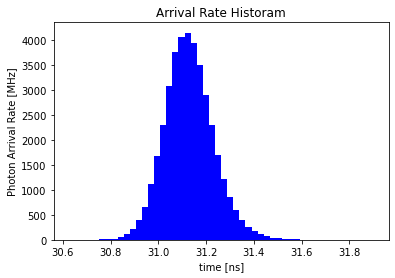

In [4]:
# Scaled time-of-flight histogram
fig = plt.figure()
ax = fig.add_subplot(111)
n, bins = np.histogram(flight_time/1000, bins=50)
binwidth = np.diff(bins)[0]
N = n / binwidth / 1e-9 / cnt_phot_fit  # [Hz] Scale counts to arrival rate
center = 0.5 * (bins[:-1] + bins[1:])
ax.bar(center, N/1e6, align='center', width=binwidth, color='b')
# ax.set_xlim([30,35])
ax.set_title('Arrival Rate Historam')
ax.set_xlabel('time [ns]')
ax.set_ylabel('Photon Arrival Rate [MHz]')
plt.show()

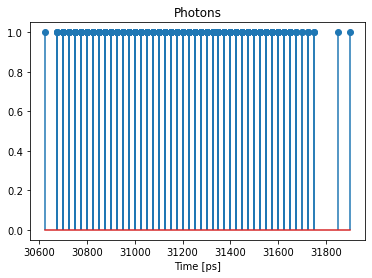

In [5]:
plt.figure()
plt.stem(flight_time, np.ones(flight_time.size))
plt.title('Photons')
plt.xlabel('Time [ps]')
plt.show()

### Now applying the curve_fit routine to my data. Code pulled from Matt Hayman's "Fit_TimeTag_Gaussian.ipynb" and adapted to fit to arbitrary exponentiated polynomials.

In [6]:
# Chebyshev polynomial matrix generator
def cheby_poly(x, M):
    """
    Parameters:
    x (array-like): Values to be evaluated on in chebyshev polynomial      \\ [Nx1]
    M (int)        : *Highest* order term of polynomial (e.g., x^2 --> M = 2) \\ []
    Returns:
    chebyshev polynomial matrix (array-like): Evaluated polynomial \\ [NxM]
    """
    
    def cheby(x, m):
        """
        Helper to calculate value of specific chebyshev order
        """
        T0 = x**0
        T1 = x**1
        if m == 0:   return T0
        elif m == 1: return T1
        else:        return 2*x*cheby(x, m-1) - cheby(x, m-2)
    
    N = len(x)
    model_out = np.zeros((N, M+1))
    for i in range(M+1):
        model_out[:, i] = cheby(x, i)
    
    return torch.tensor(model_out)

In [155]:
# build the fit model as a NN module
class Fit_Pulse(torch.nn.Module):
    def __init__(self, t_max):
        """
        Instantiate and initialize the fit parameters.
        """
        super().__init__()
   
        self.C8 = torch.nn.Parameter(-10*torch.ones(()))
        self.C7 = torch.nn.Parameter(10*torch.ones(()))
        self.C6 = torch.nn.Parameter(-10*torch.ones(()))
        self.C5 = torch.nn.Parameter(10*torch.ones(()))
        self.C4 = torch.nn.Parameter(-10*torch.ones(()))
        self.C3 = torch.nn.Parameter(10*torch.ones(()))
        self.C2 = torch.nn.Parameter(-10*torch.ones(()))    # Quadratic term amplitude
        self.C1 = torch.nn.Parameter(10*torch.ones(()))    # Linear term amplitude
        self.C0 = torch.nn.Parameter(-11*torch.ones(()))    # DC term      
        self.A  = torch.nn.Parameter(300*torch.ones(()))  # Amplitude
        self.b  = torch.nn.Parameter(40*torch.ones(()))     # Offset
        self.t_max = t_max                                    # Time elapsed per shot
        
        self.sqrt_2pi = torch.sqrt(torch.tensor(2*np.pi))
        self.sqrt_2  = torch.sqrt(torch.tensor(2.0))
        
    # Helper for numerical integration (trapezoidal method)
    @staticmethod
    def trapezoid(vals, dx):
        trap_intgrl = 0
        for i in range(len(vals)-1):
            trap_intgrl += vals[i] + vals[i+1]
        trap_intgrl *= dx/2
        return trap_intgrl

    def forward(self, t, intgrl_N):
        """
        Forward model the profile for input time t of polynomial order M (e.g., x^2 --> M=2).
        Also return the integral.
        t (array-like): time stamps (unnormalized)               \\ [Nx1]
        intgrl_N (int): number of steps in numerical integration \\ []
        """
        C8 = self.C8
        C7 = self.C7
        C6 = self.C6
        C5 = self.C5
        C4 = self.C4
        C3 = self.C3
        C2 = self.C2
        C1 = self.C1
        C0 = self.C0
        A  = self.A
        b  = self.b
        
        # orthonormalize by leveraging chebyshev polynomials, then calculate forward model
        t_norm = t / self.t_max                       # Normalize timestamps
        C = torch.eye(9, 1, dtype=float)
        C[0], C[1], C[2], C[3], C[4], C[5], C[6], C[7], C[8] = C0, C1, C2, C3, C4, C5, C6, C7, C8
        M = len(C) - 1
        t_poly_cheb = cheby_poly(t_norm, M)           # Generate chebyshev timestamp basis
        poly = t_poly_cheb @ C
        model_out = A*torch.exp(poly) + b             # Forward model
        
        # calculate the integral
        t_pts, dx = np.linspace(0, 1, intgrl_N, retstep=True)  # Normalized time vector
        t_poly_cheb = cheby_poly(t_pts, M)                        # Generate chebyshev time basis
        poly = t_poly_cheb @ C
        eval_model = A*torch.exp(poly) + b
        integral_out = self.trapezoid(eval_model, dx)            # Numerically integrate (trapezoidal)
            
        return model_out, integral_out

In [156]:
def pois_loss(prof,integral):
    """
    Poisson point process loss function
    prof: estimated photon arrival rate evaluated at
        each time tag
    integral: integral of prof at t_max
    """
    print(integral)
    print(torch.sum(torch.log(prof)))
    return integral-torch.sum(torch.log(prof))

In [157]:
# optimization parameters

rel_step_lim = 1e-15  # termination criteria based on step size
max_epochs = 1000     # maximum number of iterations/epochs
learning_rate = 1e-1  # ADAM learning rate
term_persist = 20     # relative step size averaging interval in iterations

In data set, the frequency of the sync pulses is ~14.2kHz. Therefore, t_max ~= 70.2043 usec. Might need to look into having this dynamically adjusted.

In [158]:
# # I define the maximum time as a fixed value. This is the mode of the recorded elapsed time between shots.
# # Time vector per shot (sync event)
# t_min = 0
# avg_sync_diff = ds.sync_delta.mean() * tstamp_int / 1e12  # [s]
# t_max = avg_sync_diff.item()
# dt = tstamp_int * 1e-12                                    # [s]
# t_fine = np.arange(t_min, t_max, dt)

In [159]:
# I define the maximum time as a fixed value. This is the mode of the recorded elapsed time between shots.
# Time vector per shot (sync event)
t_min = exclude_bnd[0] * 1e-12
t_max = exclude_bnd[1] * 1e-12
dt = tstamp_int * 1e-12                                    # [s]
t_fine = np.arange(t_min, t_max, dt)

In [160]:
# initialize for fit loop
fit_model = Fit_Pulse(t_max)
optimizer = torch.optim.Adam(fit_model.parameters(), lr=learning_rate)
epoch = 0
rel_step = 1e3*rel_step_lim
train_loss_lst = []
rel_step_lst = []

init_C0 = fit_model.C0.item()
init_C1 = fit_model.C1.item()
init_C2 = fit_model.C2.item()
init_C3 = fit_model.C3.item()
init_C4 = fit_model.C4.item()
init_C5 = fit_model.C5.item()
init_C6 = fit_model.C6.item()
init_C7 = fit_model.C7.item()
init_C8 = fit_model.C8.item()
init_A  = fit_model.A.item()
init_b  = fit_model.b.item()

In [161]:
# set the loss function to use a 
# Poisson point process likelihood function
loss_fn = pois_loss

In [162]:
intgrl_N = 1000                   # Set number of steps in numerical integration
t_phot_fit = flight_time * 1e-12  # [s] convert to seconds
t_phot_fit_tnsr = torch.tensor(t_phot_fit.to_numpy())

In [163]:
# perform fit
while rel_step > rel_step_lim and epoch < max_epochs:
    fit_model.train()
    pred, integral = fit_model(t_phot_fit_tnsr, intgrl_N)
    loss = loss_fn(pred, integral*cnt_phot_fit)  # add regularization here
    train_loss_lst += [loss.item()]

    # calculate relative step as an average over the last
    # term_persist iterations
    if epoch == 0:
        rel_step_lst+=[1e3*rel_step_lim]
        rel_step = 1e3*rel_step_lim
    else:
        rel_step_lst+=[(train_loss_lst[-2]-train_loss_lst[-1])/np.abs(train_loss_lst[-2])]
        rel_step = np.abs(np.array(rel_step_lst)[-term_persist:].mean())

    # update estimated parameters
    loss.backward()
    optimizer.step()
    
    # zero out the gradient for the next step
    optimizer.zero_grad()
    
    epoch+=1
    

tensor([7473765.5347], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(383211.4514, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([6115377.0153], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(382106.7054, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([5341886.8200], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(381024.0221, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([4886875.7032], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(379951.4054, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([4605040.6858], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(378892.0873, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([4420063.6088], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(377857.5580, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([4291765.0486], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(376860.1329, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([4198368.8151], dtype=torch.float64, grad_fn=<MulBackward0>)
t

tensor([3352155.7297], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(353984.3317, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([3342170.3129], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(353680.1944, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([3332189.7738], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(353375.5667, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([3322213.4490], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(353070.4083, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([3312241.0514], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(352764.6934, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([3302272.3343], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(352458.3980, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([3292307.0646], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(352151.4984, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([3282345.0342], dtype=torch.float64, grad_fn=<MulBackward0>)
t

tensor([2737239.6844], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(333595.9092, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([2727366.2437], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(333234.8733, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([2717494.0805], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(332872.6296, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([2707623.0081], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(332509.1634, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([2697753.2080], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(332144.4716, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([2687884.6644], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(331778.5441, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([2678017.3761], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(331411.3716, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([2668151.3365], dtype=torch.float64, grad_fn=<MulBackward0>)
t

tensor([2127488.8659], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(308528.4191, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([2117697.3859], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(308071.4375, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([2107907.5056], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(307612.4789, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([2098119.2233], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(307151.5253, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([2088332.5415], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(306688.5585, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([2078547.2659], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(306223.5508, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([2068763.5830], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(305756.4944, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([2058981.4903], dtype=torch.float64, grad_fn=<MulBackward0>)
t

tensor([1514222.3482], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(275031.1204, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([1504560.2780], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(274404.7044, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([1494901.0478], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(273774.6210, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([1485244.7536], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(273140.8339, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([1475591.3949], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(272503.3008, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([1465940.9745], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(271861.9756, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([1456293.4882], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(271216.8148, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([1446649.0325], dtype=torch.float64, grad_fn=<MulBackward0>)
t

tensor([913096.0379], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(226333.1719, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([903727.6738], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(225364.6579, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([894366.9492], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(224388.2940, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([885014.0707], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(223403.9962, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([875669.2410], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(222411.6848, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([866332.5749], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(221411.2657, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([857004.2741], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(220402.6471, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([847684.4553], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(21

tensor([340680.0150], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(155882.4169, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([332576.2678], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(155821.9021, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([324533.4696], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(155979.6055, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([316557.6421], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(156390.0408, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([308656.0513], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(157092.6648, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([300837.5172], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(158132.3523, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([293112.8484], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(159559.7491, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([285495.3078], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(16

tensor([-154750.7531], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(315810.9512, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([-165957.9223], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(314395.0345, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([-177298.3010], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(312830.2567, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([-188663.2708], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(311216.0790, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([-199956.1194], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(309646.7213, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([-211096.1301], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(308206.4352, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([-222020.0337], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(306966.2217, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([-232683.0144], dtype=torch.float64, grad_fn=<MulBackward0>)
t

tensor([-760792.2926], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(312261.1483, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([-770357.0438], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(312415.4222, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([-779936.2646], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(312555.2975, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([-789536.7771], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(312673.9826, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([-799162.9163], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(312767.1700, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([-808816.5504], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(312833.1242, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([-818496.3804], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(312873.0599, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([-828199.2781], dtype=torch.float64, grad_fn=<MulBackward0>)
t

tensor([-1379813.3850], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(315605.3568, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([-1389496.8372], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(315652.8074, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([-1399179.8463], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(315700.9247, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([-1408862.0878], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(315749.9351, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([-1418543.0308], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(315800.4673, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([-1428222.5657], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(315852.7172, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([-1437900.9088], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(315906.2894, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([-1447578.1537], dtype=torch.float64, grad_fn=<MulBackw

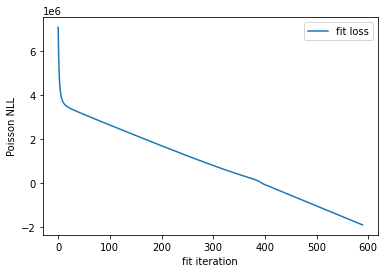

In [164]:
# plot the loss over iterations
plt.figure()
plt.plot(train_loss_lst,label='fit loss')
plt.xlabel('fit iteration')
plt.ylabel('Poisson NLL')
plt.legend()

In [165]:
t_tot_fine = np.arange(0, 60000*1e-12, dt)
pred_mod_full, integral_full = fit_model(torch.tensor(t_tot_fine), intgrl_N)

In [167]:
print('Initial C0: {}'.format(init_C0))
print('Initial C1: {}'.format(init_C1))
print('Initial C2: {}'.format(init_C2))
print('Initial C3: {}'.format(init_C3))
print('Initial C4: {}'.format(init_C4))
print('Initial C5: {}'.format(init_C5))
print('Initial C6: {}'.format(init_C6))
print('Initial C7: {}'.format(init_C7))
print('Initial C8: {}'.format(init_C8))
print('Initial A: {}'.format(init_A))
print('Initial b: {}'.format(init_b))

print('Final C0: {}'.format(fit_model.C0))
print('Final C1: {}'.format(fit_model.C1))
print('Final C2: {}'.format(fit_model.C2))
print('Final C3: {}'.format(fit_model.C3))
print('Final C4: {}'.format(fit_model.C4))
print('Final C5: {}'.format(fit_model.C5))
print('Final C6: {}'.format(fit_model.C6))
print('Final C7: {}'.format(fit_model.C7))
print('Final C8: {}'.format(fit_model.C8))
print('Final A: {}'.format(fit_model.A))
print('Final b: {}'.format(fit_model.b))

Initial C0: -11.0
Initial C1: 10.0
Initial C2: -10.0
Initial C3: 10.0
Initial C4: -10.0
Initial C5: 10.0
Initial C6: -10.0
Initial C7: 10.0
Initial C8: -10.0
Initial A: 300.0
Initial b: 40.0
Final C0: -12.835498809814453
Final C1: 8.17318058013916
Final C2: -8.093628883361816
Final C3: 12.196846961975098
Final C4: -5.094864845275879
Final C5: 9.804187774658203
Final C6: -10.643746376037598
Final C7: 12.310578346252441
Final C8: -8.908130645751953
Final A: 298.16180419921875
Final b: -18.25648307800293


In [168]:
print("Sample average arrival time: {:.4f} ns".format(torch.mean(t_phot_fit_tnsr)*1e9))

Sample average arrival time: 31.1317 ns


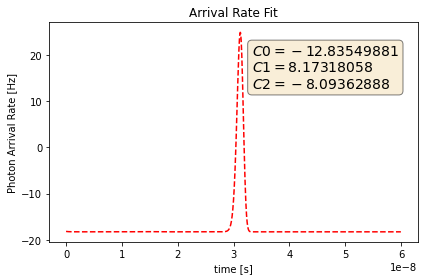

In [169]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Arrival rate fit
fit_rate = pred_mod_full.detach().numpy()  # [Hz] Fitted arrival rate
ax.plot(t_tot_fine, fit_rate,'r--')
ax.set_title('Arrival Rate Fit')
ax.set_xlabel('time [s]')
ax.set_ylabel('Photon Arrival Rate [Hz]')
textstr = '\n'.join((
    r'$C0=%.8f$' % (fit_model.C0),
    r'$C1=%.8f$' % (fit_model.C1),
    r'$C2=%.8f$' % (fit_model.C2)))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.55, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.tight_layout()
plt.show()


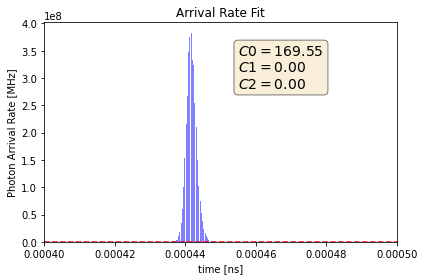

In [144]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Scaled histogram
n, bins = np.histogram(flight_time/1000, bins=2000)
binwidth = np.diff(bins)[0]
N = n / binwidth / 1e-9 / cnt_phot_fit  # [Hz] Scaling counts to arrival rate
center = 0.5 * (bins[:-1] + bins[1:])
ax.bar(center, N/1e6, align='center', width=binwidth, color='b', alpha=0.5)

# Arrival rate fit
fit_rate = pred_mod_full.detach().numpy()  # [Hz] Fitted arrival rate
ax.plot(t_fine*1e9, fit_rate/1e6,'r--')
ax.set_xlim([26, 40])
ax.set_title('Arrival Rate Fit')
ax.set_xlabel('time [ns]')
ax.set_ylabel('Photon Arrival Rate [MHz]')
textstr = '\n'.join((
    r'$C0=%.2f$' % (torch.exp(fit_model.C0)),
    r'$C1=%.2f$' % (torch.exp(fit_model.C1)),
    r'$C2=%.2f$' % (torch.exp(fit_model.C2))))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.55, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.tight_layout()
plt.show()



### Graveyard ###

In [93]:
class NumericalIntegrator:
    def riemann(f, eval_pts, dx):
        integral = 0
        for i in range(len(eval_pts)):
            integral += f(eval_pts[i])
        integral *= dx
        return integral

    def trapezoidal(f, eval_pts, dx):
        integral = 0
        for i in range(len(eval_pts)-1):
            integral += f(eval_pts[i]) + f(eval_pts[i+1])
        integral *= dx / 2
        return integral

    def simpsons(f, eval_pts, dx):
        integral = 0
        for i in range(len(eval_pts)-2):
            integral += f(eval_pts[i]) + 4*f(eval_pts[i+1]) + f(eval_pts[i+2])
        integral *= dx / 2 / 3
        return integral
